In [25]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score



In [22]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

# Simple Regression Model


In [24]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate',
       'target_12m_final', 'sharpe_1y', 'revenue_yoy', 'ebitda_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'log_revenue', 'log_ebitda', 'log_ebit', 'log_marketcap', 'log_equity',
       'ebit_margin', 'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps',
       'ret_12m_vol', 'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y',
       'vol_over_sma', 'cap_category', 'cap_Large Cap', 'cap_Mega Cap',
       'cap_Mid Cap', 'cap_Small Cap'],
      dtype='object')

Simplicidad: Es la referencia más básica y fácil de interpretar. Además este modelo de Regresión lineal sirve como baseline para comparar modelos más complejos (XGBoost, Random Forest,etc). Sus coeficientes muestran la relación entre cada variable y el target (positivo/negativo y fuerza). Es rápido y robusto ya que permite detectar si hay problemas graves (multicolinealidad, outliers, etc.) antes de probar modelos más avanzados. Por últimos, la regresión lineal tiene un riesgo de sobreajuste bajo

Fold 1: MSE=0.2027, R2=-1.0379
Fold 2: MSE=0.4448, R2=-1.2055
Fold 3: MSE=0.0844, R2=-0.2994
Fold 4: MSE=0.1848, R2=0.0698
Fold 5: MSE=0.1179, R2=-0.2619

=== Resultados Globales ===
MSE promedio: 0.2069
R2 promedio: -0.5470


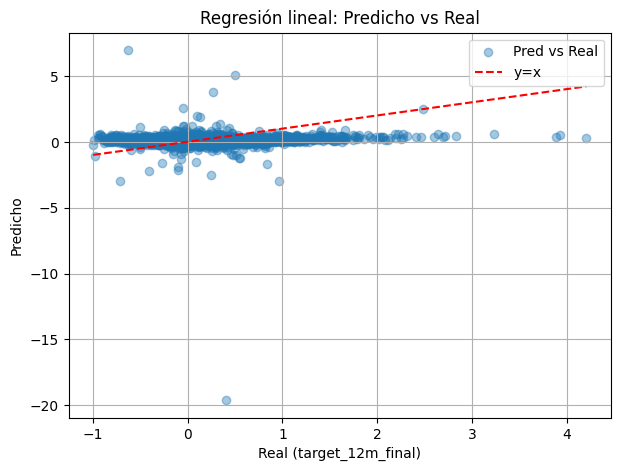


Top 10 variables más influyentes (absoluto):
ret_12m         -0.378081
dist_max_1y     -0.318901
volatility_1y    0.316142
ret_6m          -0.193964
dist_min_1y      0.130920
ret_12m_vol      0.114798
revenue_yoy     -0.087403
ret_6m_vol       0.046996
fcf_yield        0.046466
log_marketcap   -0.045781
dtype: float64


In [28]:
# 1. Prepara los datos
features = [
    col for col in data_base.columns
    if col not in [
        'ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final'
    ] and not col.startswith('target')
]
# El target es el retorno futuro a 12m
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
X = data_base[features].replace([np.inf, -np.inf], np.nan)

# Elimina filas con NaN en X o y
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 2. Ordena por fecha para TimeSeriesSplit
data_filtered = data_filtered.sort_values('date')
X = X.loc[data_filtered.index]
y = y.loc[data_filtered.index]

# 3. Validación temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
mse_scores, r2_scores = [], []

y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Modelo lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_true_all.append(y_test)
    y_pred_all.append(y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Fold {fold+1}: MSE={mse:.4f}, R2={r2:.4f}")

# 4. Métricas medias
print("\n=== Resultados Globales ===")
print(f"MSE promedio: {np.mean(mse_scores):.4f}")
print(f"R2 promedio: {np.mean(r2_scores):.4f}")

# 5. Análisis visual de ajuste global
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
plt.figure(figsize=(7, 5))
plt.scatter(y_true_all, y_pred_all, alpha=0.4, label="Pred vs Real")
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--', label="y=x")
plt.title("Regresión lineal: Predicho vs Real")
plt.xlabel("Real (target_12m_final)")
plt.ylabel("Predicho")
plt.legend()
plt.grid()
plt.show()

# 6. Interpretación de coeficientes (importancia)
coefs = pd.Series(model.coef_, index=features)
coefs = coefs.sort_values(key=abs, ascending=False)
print("\nTop 10 variables más influyentes (absoluto):")
print(coefs.head(10))
